In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
# Plot Time Series Graph
def plot_time_series(time, series, format='-', start=0, end=None, label=None):
  plt.plot(time[start:end], series[start:end], format, label=label)
  plt.xlabel('Time')
  plt.ylabel('Value')
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)  

# To generate trend
def trend(time, slope=0):
  return time * slope

# To generate Seasonal Pattern
def seasonal_pattern(season_time):
  return np.where(season_time < 0.4,
                  np.cos(season_time * 2 * np.pi),
                  1 / np.exp(3 * season_time))
  
# To generate seasonality data
def seasonality(time, period, amplitude=1, phase=0):
  season_time = ((time + phase) % period) / period
  return amplitude * seasonal_pattern(season_time)

# To generate noise
def white_noise(time, noise_level=1, seed=None):
  rnd = np.random.RandomState(seed)
  return rnd.randn(len(time)) * noise_level


def window_dataset(series, window_size, batch_size=32, shuffle_buffer=1000):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(size=window_size+1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
  dataset = dataset.shuffle(shuffle_buffer)
  dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
  dataset = dataset.batch(batch_size).prefetch(1)
  
  return dataset


def model_forecast(model, series, window_size):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda w: w.batch(window_size))
  dataset = dataset.batch(32).prefetch(1)
  forecast = model.predict(dataset)

  return forecast


def sequential_window_dataset(series, window_size):
  series = tf.expand_dims(series, axis=-1)
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size+1, shift=window_size, drop_remainder=True)
  dataset = dataset.flat_map(lambda w: w.batch(window_size+1))
  dataset = dataset.map(lambda w: (w[:-1], w[1:]))
  dataset = dataset.batch(1).prefetch(1)

  return dataset

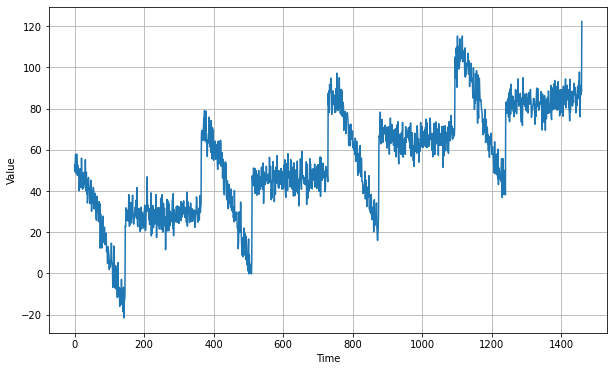

In [3]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level=noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_time_series(time, series)
plt.show()

In [4]:
split_time = 1000

time_train = time[:split_time]
time_valid = time[split_time:]

x_train = series[:split_time]
x_valid = series[split_time:]

In [5]:
x_train.shape, x_valid.shape

((1000,), (461,))

In [6]:
for X_batch, y_batch in sequential_window_dataset(tf.range(10), 3):
    print(X_batch.numpy(), y_batch.numpy())

[[[0]
  [1]
  [2]]] [[[1]
  [2]
  [3]]]
[[[3]
  [4]
  [5]]] [[[4]
  [5]
  [6]]]
[[[6]
  [7]
  [8]]] [[[7]
  [8]
  [9]]]


In [7]:
class ResetStatesCallback(tf.keras.callbacks.Callback):
  def on_epoch_begin(self, epoch, logs):
    self.model.reset_states()

# Forecasting with LSTM

In [8]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

WINDOW_SIZE = 30
train_set = sequential_window_dataset(x_train, WINDOW_SIZE)

model = tf.keras.Sequential([
    tf.keras.layers.LSTM(100, return_sequences=True, stateful=True, batch_input_shape=[1, None, 1]),
    tf.keras.layers.LSTM(100, stateful=True, return_sequences=True),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x*200)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch/30)
)
reset_states = ResetStatesCallback()

model.compile(
    loss = tf.keras.losses.Huber(),
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9),
    metrics = ['mae']
)

history = model.fit(train_set,
                    epochs=100,
                    callbacks=[lr_schedule,
                               reset_states])

Epoch 1/100
33/33 [==============================] - 8s 16ms/step - loss: 90.9191 - mae: 91.4191
Epoch 2/100
33/33 [==============================] - 0s 15ms/step - loss: 83.9873 - mae: 84.4873
Epoch 3/100
33/33 [==============================] - 0s 14ms/step - loss: 75.9798 - mae: 76.4798
Epoch 4/100
33/33 [==============================] - 0s 15ms/step - loss: 67.3260 - mae: 67.8260
Epoch 5/100
33/33 [==============================] - 1s 15ms/step - loss: 57.9995 - mae: 58.4995
Epoch 6/100
33/33 [==============================] - 0s 15ms/step - loss: 47.9742 - mae: 48.4742
Epoch 7/100
33/33 [==============================] - 0s 14ms/step - loss: 37.2820 - mae: 37.7817
Epoch 8/100
33/33 [==============================] - 0s 14ms/step - loss: 25.9657 - mae: 26.4651
Epoch 9/100
33/33 [==============================] - 0s 15ms/step - loss: 15.1205 - mae: 15.6161
Epoch 10/100
33/33 [==============================] - 0s 14ms/step - loss: 10.1845 - mae: 10.6703
Epoch 11/100
33/33 [=========

(1e-08, 0.0001, 0.0, 30.0)

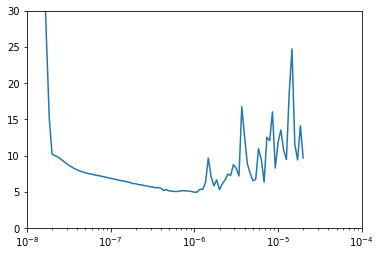

In [9]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [17]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

WINDOW_SIZE = 30
train_set = sequential_window_dataset(x_train, WINDOW_SIZE)
valid_set = sequential_window_dataset(x_valid, WINDOW_SIZE)

model = tf.keras.Sequential([
    tf.keras.layers.LSTM(100, return_sequences=True, stateful=True, batch_input_shape=[1, None, 1]),
    tf.keras.layers.LSTM(100, stateful=True, return_sequences=True),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x*200)
])

model.compile(
    loss = tf.keras.losses.Huber(),
    optimizer = tf.keras.optimizers.SGD(learning_rate=5e-7, momentum=0.9),
    metrics = ['mae']
)

reset_states = ResetStatesCallback()
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'my_checkpoint.h5', save_best_only=True
)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=50)


history = model.fit(train_set,
                    epochs=100,
                    validation_data=valid_set,
                    callbacks=[early_stopping,
                               model_checkpoint,
                               reset_states])

Epoch 1/100
33/33 [==============================] - 4s 44ms/step - loss: 30.0122 - mae: 30.5051 - val_loss: 13.0810 - val_mae: 13.5746
Epoch 2/100
33/33 [==============================] - 1s 19ms/step - loss: 15.3618 - mae: 15.8570 - val_loss: 10.0991 - val_mae: 10.5941
Epoch 3/100
33/33 [==============================] - 1s 18ms/step - loss: 10.9284 - mae: 11.4173 - val_loss: 11.2192 - val_mae: 11.7083
Epoch 4/100
33/33 [==============================] - 1s 18ms/step - loss: 9.8165 - mae: 10.3052 - val_loss: 12.2806 - val_mae: 12.7757
Epoch 5/100
33/33 [==============================] - 1s 18ms/step - loss: 7.8424 - mae: 8.3317 - val_loss: 9.6437 - val_mae: 10.1336
Epoch 6/100
33/33 [==============================] - 1s 18ms/step - loss: 7.1708 - mae: 7.6561 - val_loss: 10.6124 - val_mae: 11.1036
Epoch 7/100
33/33 [==============================] - 1s 18ms/step - loss: 5.9200 - mae: 6.4041 - val_loss: 10.1595 - val_mae: 10.6522
Epoch 8/100
33/33 [==============================] - 1s 

In [18]:
model = tf.keras.models.load_model("my_checkpoint.h5")

In [19]:
model.reset_states()
model_forecast = model.predict(series[np.newaxis, :, np.newaxis])
model_forecast = model_forecast[0, split_time - 1:-1, 0]

In [20]:
model_forecast.shape

(461,)

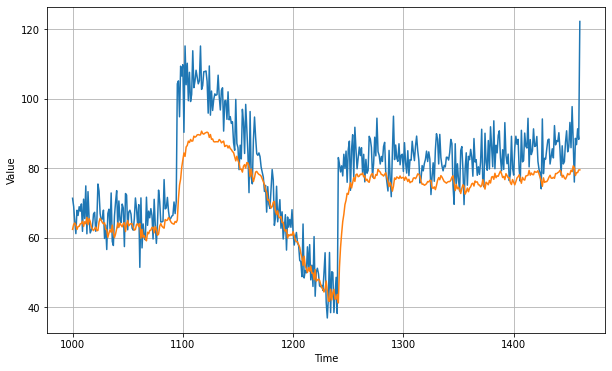

In [21]:
plt.figure(figsize=(10, 6))
plot_time_series(time_valid, x_valid)
plot_time_series(time_valid, model_forecast)

In [22]:
model_forecast_mae = tf.keras.metrics.mean_absolute_error(x_valid, model_forecast)
model_forecast_mae

<tf.Tensor: shape=(), dtype=float32, numpy=7.532669>